In [1]:
import pandas as pd
data = pd.read_csv('modelling_data.csv')
data = data.dropna(subset=['message_body'])
data.head(2) 

,message_type,author_id,author_type,severity,message_body,created_at,dow,month,hour,doy,...,includes_url,polarity,len,word_count,avg_word,stopwords,number_cnt,contains_numbers,contains_upper,upper_cnt
0,ticket,354084,NaN,urgent,haha. I love the link to the track. Thanks!,2017-11-14 13:53:58+00:00,Tuesday,November,13,318,...,0,pos,44,9,3.888889,3,0,0,0,1
1,chat,266588,lead,urgent,Can you follow me?,2017-11-22 14:17:11+00:00,Wednesday,November,14,326,...,0,neu,19,4,3.750000,1,0,0,0,0


**Model Selection**

Choosing to go with **k-means** here being one of the easiest algos to implement for such a problem. Easy to attempt clustering with a lot of different number of clusters and use an elbow approach to optimise. 


**Feature Extraction**

It can be noted that k-means (and minibatch k-means) are very sensitive to feature scaling and that in this case the IDF weighting helps improve the quality of the clustering by quite a lot. This is the main reasoning behind the choise of TFIDVect over HashVect (though the latter could also be used with an L2 norm scaling). Additionally testing the use of latent semantic analysis (LSA -> SVD component) for dimensionality reduction.

**Evaluation Metric**

3 potential metrics to use where ground truth labels are not known in clustering. a) Devies-Bouldin Index b) Silhouette Coefficient and c) Calinski-Harabasz Index.

Chose to go with Silhouette Coefficient here as it's a lot more intuitive to use and to conceptually understand.

A simple intuitive explanation is:

    -1 <= coef < 0 then point would have been better off assigned to a different cluster, closer to -1 worse off it is
    coef = 0 right at the inflection point between clusters
    0 < coef <= 1 well-assigned, closer to 1 higher confidence

Actual definition: The Silhouette Coefficient is defined for each sample and is composed of two scores

**a**: The mean distance between a sample and all other points in the same class.

**b**: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

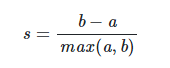
 
The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

Below I wanted to generate both text based features, but also leverage all the info in the other features we had in the initial dataset, so I attempted to combined the 2 sparse matrices generated from vectrorizing each feature set, but unfortunately I was running out of memory locally. This would have been a nice addition if more compute resources were available!

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.95, min_df=2, stop_words='english')
vectorizer_pipeline = make_pipeline(vectorizer, TfidfTransformer())
X = vectorizer_pipeline.fit_transform(data['message_body'].values)

lsa_n_components = [100, 500, 1000]

for n_components in lsa_n_components:
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X_train = lsa.fit_transform(X)
    print('Explained variance with %i components = %.2f%%' % (n_components, 100*svd.explained_variance_ratio_.sum()))
    print("n_samples: %d, n_features: %d" % X_train.shape)

Explained variance with 100 components = 21.87%
n_samples: 14875, n_features: 100
Explained variance with 500 components = 52.20%
n_samples: 14875, n_features: 500
Explained variance with 1000 components = 69.82%
n_samples: 14875, n_features: 1000


Let's go with 1000 components or we may try dropping dimensionality reduction all together.

Skip this step as not enough memory locally to run.

In [3]:
# from sklearn.preprocessing import OneHotEncoder
# Other columns feature extractions
# print("*"*50)
# print("Extracting other features from the training dataset using a sparse vectorizer")
# enc = OneHotEncoder()
# X2 = enc.fit_transform(data.drop(['message_body', 'created_at', 'author_id', 'url', 'avg_word', 'len', 'doy', 
#                                   'upper_cnt', 'handle', 'stopwords', 'word_count'], axis=1).fillna('0'))
# print("done in %fs" % (time() - t0))

# from scipy.sparse import hstack
# print('Combining sparse matrices...')
# X = hstack([X, X2]).toarray()
# print("done in %fs" % (time() - t0))
# print("n_samples: %d, n_features: %d" % X.shape)

### Model Tuning

In [10]:
from sklearn.feature_extraction.text import HashingVectorizer
from time import time
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
import itertools

min_df = [0.001, 0.01] # [0.01, 0.05, 0.10, 0.15]
max_df = [0.25, 0.5, 0.75] # [0.5, 0.75, 0.95, 0.99]
ngram_range = (1, 3) # (1, 3)
n_clusters = [2, 3, 4, 5] #[2, 3, 5, 10, 20, 30, 50]

sse = []
silhouette_avg = []
params = {}
run_top_terms = {}

i=0
for k in range(len(min_df)):
    for j in range(len(max_df)):
        for n in n_clusters:
            params[i] = {'min_df': min_df[k], 'max_df': max_df[j], 'ngrams': ngram_range, 'clusters': n}
            t0 = time()
            print("*"*50)
            print('Run %i with params min_df: %.2f max_df: %.2f ngrams: %i n_clusters: %i' %
                 (i, min_df[k], max_df[j], ngram_range[1], n))
            print("Extracting text features from the training dataset using a sparse vectorizer")
            # vectorizer = HashingVectorizer(n_features=10000, stop_words='english', alternate_sign=False, norm='l2')
            vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=max_df[j], min_df=min_df[k], stop_words='english',
                                         ngram_range=ngram_range)
            vectorizer_pipeline = make_pipeline(vectorizer, TfidfTransformer())
            X = vectorizer_pipeline.fit_transform(data['message_body'].values)
#                 svd = TruncatedSVD(1000) # if LSA active
#                 X = svd.fit_transform(X)
            normalizer = Normalizer(copy=False)
            normalizer.fit_transform(X)
            print("n_samples: %d, n_features: %d" % X.shape)
#                 km = MiniBatchKMeans(n_clusters=n, init='k-means++', n_init=1, init_size=1000, batch_size=1000, 
#                                      verbose=False)
            model = KMeans(n_clusters=n, init='k-means++', max_iter=100, n_init=1, verbose=False)
            model.fit(X)
            sse.append(model.inertia_)
            silhouette_avg.append(metrics.silhouette_score(X, model.labels_, sample_size=1000))
            print("-- Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, model.labels_, sample_size=1000))
#                 original_space_centroids = svd.inverse_transform(km.cluster_centers_) # if LSA
#                 order_centroids = original_space_centroids.argsort()[:, ::-1] # if LSA
            order_centroids = model.cluster_centers_.argsort()[:, ::-1]
            print("Top terms per cluster:")
            terms = vectorizer.get_feature_names()
            cluster_top_terms = {}
            for cluster_number in range(n):
                cluster_top_terms_list = []
                print("> Cluster %d:" % cluster_number, end='')
                for ind in order_centroids[cluster_number, :20]:
                    print(' %s' % terms[ind], end='')
                    cluster_top_terms_list.append(terms[ind])
                print('\n')
                cluster_top_terms[cluster_number] = cluster_top_terms_list
            run_top_terms[i] = cluster_top_terms
            i+=1
print("done in %0.3fs" % (time() - t0))

**************************************************
Run 0 with params min_df: 0.00 max_df: 0.25 ngrams: 3 n_clusters: 2
Extracting text features from the training dataset using a sparse vectorizer
n_samples: 14875, n_features: 1454
-- Silhouette Coefficient: 0.022
Top terms per cluster:
> Cluster 0: thanks thank spotify app songs dm just song music playlist album sent like iphone play version guys did yes work

> Cluster 1: account help premium family email student spotify charged need subscription hi need help payment facebook card premium account log password free plan

**************************************************
Run 1 with params min_df: 0.00 max_df: 0.25 ngrams: 3 n_clusters: 3
Extracting text features from the training dataset using a sparse vectorizer
n_samples: 14875, n_features: 1454
-- Silhouette Coefficient: 0.017
Top terms per cluster:
> Cluster 0: thank thanks songs dm spotify song just music app playlist sent album like guys play did yes work ve don

> Cluster 1: ver

n_samples: 14875, n_features: 1454
-- Silhouette Coefficient: 0.018
Top terms per cluster:
> Cluster 0: set account country offline united states united uk states offline mode change account family hulu account won trying hi usa storage login mode start

> Cluster 1: thank working did good love reply works yes sure guys ll getting help fine sent fixed problem try spotify work

> Cluster 2: thanks spotify account help premium just app dm songs hi music song like ve need don sent hey guys playlist

> Cluster 3: help ve thanks account fi favorite fb fb account feature features feedback feel feels figured figure far file files filter finally

> Cluster 4: page artist page artist blank login help trying family spotify artists just takes album account link error facebook premium time loading

**************************************************
Run 12 with params min_df: 0.01 max_df: 0.25 ngrams: 3 n_clusters: 2
Extracting text features from the training dataset using a sparse vectorizer
n_sam

n_samples: 14875, n_features: 142
-- Silhouette Coefficient: 0.050
Top terms per cluster:
> Cluster 0: thanks thank just songs music dm like spotify app guys ve playlist don album sent work did know time ll

> Cluster 1: account help premium family student email charged need spotify subscription hi facebook plan card premium account spotify premium payment free log got

> Cluster 2: version spotify iphone android ios app 11 ios 11 latest update using 10 windows updated phone just screen issue music desktop

> Cluster 3: song play songs playlist album playing available doesn music artist just spotify app won phone error like hey listen happens

**************************************************
Run 23 with params min_df: 0.01 max_df: 0.75 ngrams: 3 n_clusters: 5
Extracting text features from the training dataset using a sparse vectorizer
n_samples: 14875, n_features: 142
-- Silhouette Coefficient: 0.072
Top terms per cluster:
> Cluster 0: account help premium family student email charge

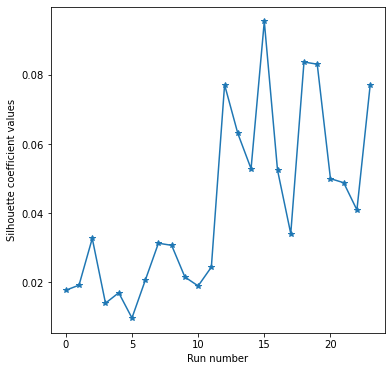

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.plot(range(len(silhouette_avg)), silhouette_avg, '-*')
plt.xlabel(r'Run number')
plt.ylabel('Silhouette coefficient values')
plt.show()

I re-run a parameter search several times, the first thing I noticed was that min_df was the most significant contributing factor towards silhouette score. The main issue here was that the more aggressively we pruned sparse words from our limited corpus of ~23k distinct words, we ended up with very few words per post to differentiate between clusters. The issue is with optimising for silhouette score. We end up with highly distinguishable clusters in a higher-dimensional place but in human terms we can't really distinguish between them. Probably an indication that silhouette score is not a very good measure in this case. Unfortunately didn't have time to investigate topic and word coherence measures.

Maxing out at 12 clusters before we start having serious overlap. 12 may not be necessarily the optimal **interpretable** number but we can explore anything in the range 2-12.

Leveraging bi-grams and tri-grams helped a bit.

In [12]:
import numpy as np
print('Run %i has the best performance, Silhouette Coefficient %.3f with params: %s' 
      % (np.argmax(silhouette_avg), max(silhouette_avg), params[np.argmax(silhouette_avg)]))


print('Top terms for most performant clustering config: \n')
for key, value in run_top_terms[np.argmax(silhouette_avg)].items():
    print('Cluster %i terms: %s' % (key, value))

Run 15 has the best performance, Silhouette Coefficient 0.095 with params: {'min_df': 0.01, 'max_df': 0.25, 'ngrams': (1, 3), 'clusters': 5}
Top terms for most performant clustering config: 

Cluster 0 terms: ['thank', 'll', 'ok', 'dm', 'good', 'guys', 'did', 'sent', 'working', 'love', 'just', 'spotify', 'hi', 'really', 'help', 'service', 'got', 'music', 'yes', 'account']
Cluster 1 terms: ['version', 'spotify', 'android', 'iphone', 'ios', '11', 'ios 11', 'latest', 'app', 'using', '10', 'update', 'updated', 'windows', 'phone', 'just', 'desktop', 'issue', 'device', 'screen']
Cluster 2 terms: ['songs', 'song', 'playlist', 'play', 'playing', 'album', 'downloaded', 'playlists', 'like', 'app', 'listen', 'spotify', 'available', 'artist', 'just', 'hey', 'add', 'phone', 'way', 'music']
Cluster 3 terms: ['thanks', 'help', 'guys', 'just', 'dm', 've', 'sent', 'got', 'spotify', 'problem', 'update', 'll', 'working', 'issue', 'hey', 'account', 'hi', 'app', 'email', 'really']
Cluster 4 terms: ['accoun

From the above we could construct themes as such:

1) General

2) Update related issue

3) Content related query (eg. song, artist or playlist availability)

4) Technical issue

5) Subscription and account related issue (eg. family account, premium subscription, student account)

Let's create a map for those.

In [43]:
topic_map = {0: 'General', 1: 'Update related issue', 2: 'Content related query', 3: 'Technical issue', 
             4: 'Subscription and account related issue'}

Let's finalize this model.

In [44]:
params = {'min_df': 0.01, 'max_df': 0.25, 'ngrams': (1, 3), 'clusters': 5}
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=params['max_df'], min_df=params['min_df'], stop_words='english', 
                             ngram_range=params['ngrams'])
pipeline = make_pipeline(vectorizer, TfidfTransformer(), Normalizer(copy=False),
                                    KMeans(n_clusters=params['clusters'], init='k-means++', 
                                           max_iter=100, n_init=1, verbose=False))
pipeline.fit(data['message_body'].values)
print("done in %0.3fs" % (time() - t0))

done in 1.343s


In [69]:
pipeline.predict(data['message_body'].values)
res = pipeline.steps[3][1].cluster_centers_.argsort()[:, ::-1]
terms = pipeline.steps[0][1].get_feature_names()
for cluster in range(len(res)):
    print("> Cluster %d:" % cluster, end='')
    for ind in res[cluster, :20]:
        print(' %s' % terms[ind], end='')
    print('\n')

> Cluster 0: spotify account premium need doesn just work help song songs guys got good going getting fine free fix having feature

> Cluster 1: thank ll ok dm good guys did sent working just love spotify hi really help service got yes music account

> Cluster 2: app iphone spotify phone desktop ios android update music just songs time playing doesn version ve updated downloaded song does

> Cluster 3: thanks help guys just spotify ve got problem dm working hey update hi issue account email did getting 10 try

> Cluster 4: spotify account help just premium songs music hi like song ve family don dm playlist version need hey email student



In [52]:
data['topic_number'] = pipeline.predict(data['message_body'].values)
data['topic_name'] = data['topic_number'].map(topic_map)

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

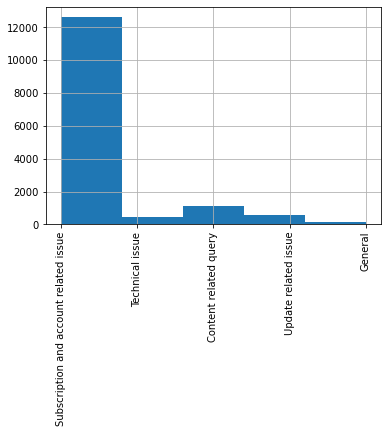

In [59]:
data.topic_name.hist(bins=5)
plt.xticks(rotation=90)

### Final remarks

This isn't very good. Results are extremely skewed and visually inspecting some samples most are not a great match. 

I think the issue here is that the data have a very specific vocabulary, a bag-of-words approach would have probably worked better as it would better adapt to the use-case specific vocabulary.

In [68]:
data.to_csv('final_results.csv')

Let's try with a different approach for interpreting results (theoretically interpretability should be higher here). Unfortunately these are not very useful as the base classes don't have predict methods so can't be used in a production system.

In [16]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [60]:
params = {'min_df': 0.01, 'max_df': 0.25, 'ngrams': (1, 3), 'clusters': 5}
t0 = time()
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=params['max_df'], min_df=params['min_df'], stop_words='english', 
                             ngram_range=params['ngrams'])
vectorizer_pipeline = make_pipeline(vectorizer, TfidfTransformer())
X = vectorizer_pipeline.fit_transform(data['message_body'].values)
##                 LSA active
#                 svd = TruncatedSVD(1000)
#                 X = svd.fit_transform(X)
normalizer = Normalizer(copy=False)
normalizer.fit_transform(X)
model = LatentDirichletAllocation(n_components=params['clusters'], max_iter=5, learning_method='online', learning_offset=50.)
# model = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online', learning_offset=50.)
# model = NMF(n_components=n, alpha=.1, l1_ratio=.5)
# model = NMF(n_components=n, beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5)
model.fit(X)
print("Top terms per cluster:")
terms = vectorizer.get_feature_names()
print_top_words(model, terms, 20)

Top terms per cluster:
Topic 0: thank help iphone problem does need 10 didn sure support ios using desktop windows issues having spotify account times im app
Topic 1: thanks like want playlist don songs playlists way available really add facebook make new device access right artists happens updated
Topic 2: premium account family email student know charged trying help free card subscription getting got payment yes hello let months won
Topic 3: music spotify guys android app issue did time working fix version playing phone good think day log listen able going
Topic 4: dm album work doesn song sent ve ll play artist error service message ok love tried works try link albums



From the above we could construct themes as such:

1) Update related issue

2) Subscription related query

3) Technical issue

4) Account related issue (login, family-accounts)

5) Playlist syncing

### Next steps
1. Gaussian mixture model - probabilistic, so we can assess probability of being assigned to correct cluster and optimise with a log-loss function
2. LDA based topic modelling as an alternative (with GenSim/LDAVis for visual analysis)